In [93]:
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial

In [94]:
save_folder = "./visualization/"
dde.config.set_default_float("float64")
origin_ns = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])

Set the default float type to float64


In [95]:
def plot_2d(x, y, solution, title):
    plt.scatter(x, y, c=solution, cmap='viridis')
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    # Add a colorbar
    plt.colorbar()
    # Show the plot
    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

def contour_plot(X, Y, Z, title):
    plt.style.use('_mpl-gallery-nogrid')
    levels = np.linspace(np.min(Z), np.max(Z), 25)
    # plot
    fig, ax = plt.subplots()
    ax.plot(X, Y, 'o', markersize=2, color='lightgrey')
    ax.tricontour(X, Y, Z, levels=levels)

    ax.set(xlim=(-3, 3), ylim=(-3, 3))

    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

In [96]:
def exact_sol(f):
    ns = origin_ns
    x = f[:, 0:1]
    y = f[:, 1:2]
    return np.sin(ns[0]*np.pi*(x + 1)*0.5)*np.sin(ns[1]*np.pi*(y + 1)*0.5)
def exact2(f):
    ns = origin_ns
    print("f",f)
    x = f[0]
    y = f[1]
    return np.sin(ns[0]*np.pi*(x + 1)*0.5)*np.sin(ns[1]*np.pi*(y + 1)*0.5)

In [97]:
def pde(netw_in, netw_out, n1, n2):
    dy_xx = dde.grad.hessian(netw_out, netw_in, i=0, j=0)
    dy_yy = dde.grad.hessian(netw_out, netw_in, i=1, j=1)
    return 0.5*(dy_xx + dy_yy)+(n1**2+n2**2)*(np.pi**2)*netw_out/8


def boundary(_, on_boundary):
    return on_boundary

In [98]:
def generate_test_data(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    test_x, test_y = np.meshgrid(x, y)
    test_x = test_x.reshape(-1)
    test_y = test_y.reshape(-1)
    return np.vstack((test_x, test_y)).T
    

def get_solution(data,model):
    solution = np.hstack([model.predict(el) for el in data])
    return solution

def graph_shreodinger(x,y,z,title,fig,ax,i,j):
    fig.set_size_inches(10, 10)
    fig.suptitle(title)
    contour = ax[i][j].tricontour(x, y, z)
    ax[i][j].clabel(contour, inline=1, fontsize=10)

def initial_points(points, values):
    tps = []
    for i in range(len(points)):
        tp = dde.PointSetBC(points[i], values[i])
        tps.append(tp)
    return tps

def get_value(points,n1,n2):
    tmp1 = np.sin(n1 * np.pi * (points[:, :, 0] + 1) / 2)
    tmp2 = np.sin(n2 * np.pi * (points[:, :, 1] + 1 ) / 2)
    res = tmp1 * tmp2
    return res.reshape(1, -1)[0]

Compiling model...
'compile' took 0.000421 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric   
0         [2.26e-03, 2.20e-01, 2.82e-01, 2.79e-01, 2.23e-01, 1.00e+00]    [2.26e-03, 2.20e-01, 2.82e-01, 2.79e-01, 2.23e-01, 1.00e+00]    [1.03e+00]    
1000      [2.58e-04, 4.92e-07, 8.98e-06, 4.50e-06, 6.52e-06, 1.03e-05]    [2.58e-04, 4.92e-07, 8.98e-06, 4.50e-06, 6.52e-06, 1.03e-05]    [9.96e-01]    
2000      [1.40e-04, 1.93e-08, 6.03e-08, 1.30e-07, 3.13e-07, 2.49e-07]    [1.40e-04, 1.93e-08, 6.03e-08, 1.30e-07, 3.13e-07, 2.49e-07]    [9.98e-01]    

Best model at step 2000:
  train loss: 1.41e-04
  test loss: 1.41e-04
  test metric: [9.98e-01]

'train' took 24.072280 s

Compiling model...
'compile' took 0.000414 s

Training model...

Step      Train loss                                                      Test loss                                                   

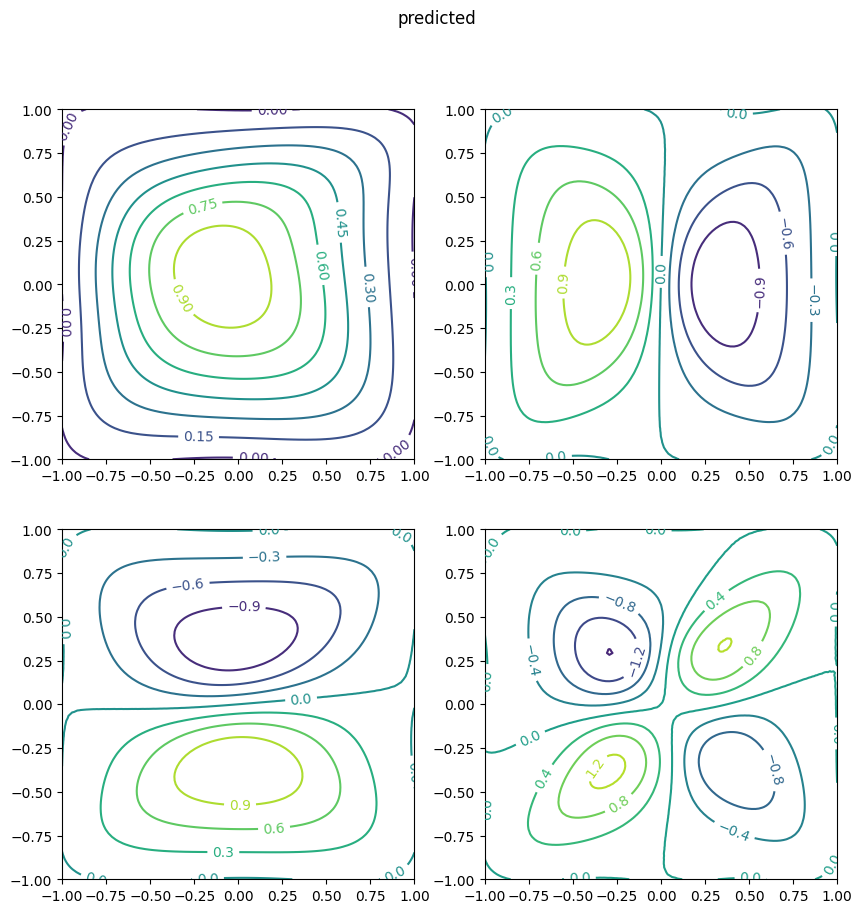

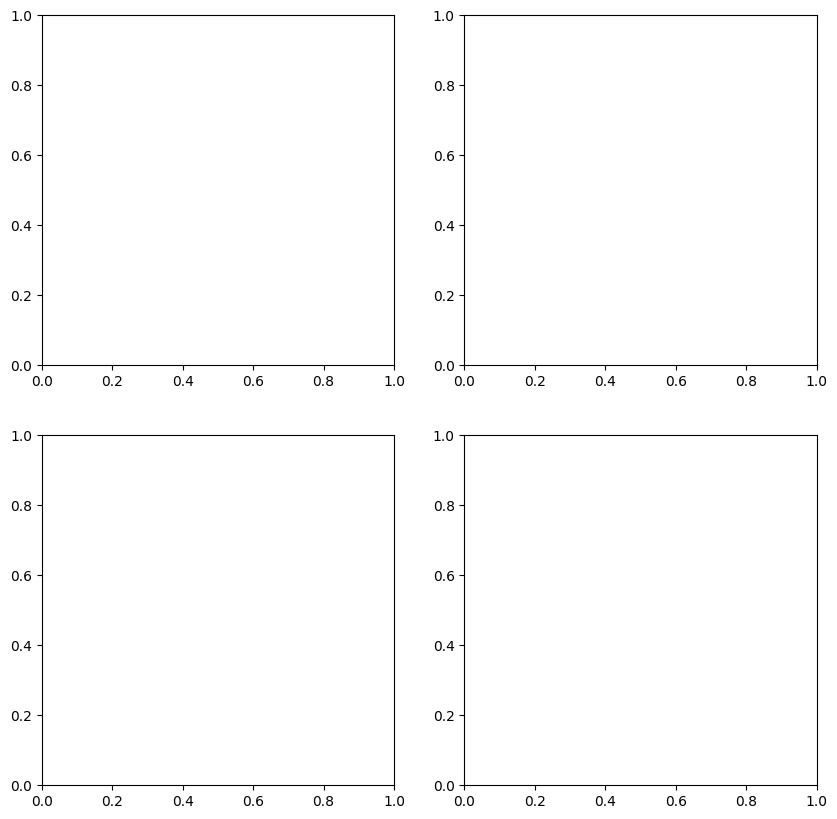

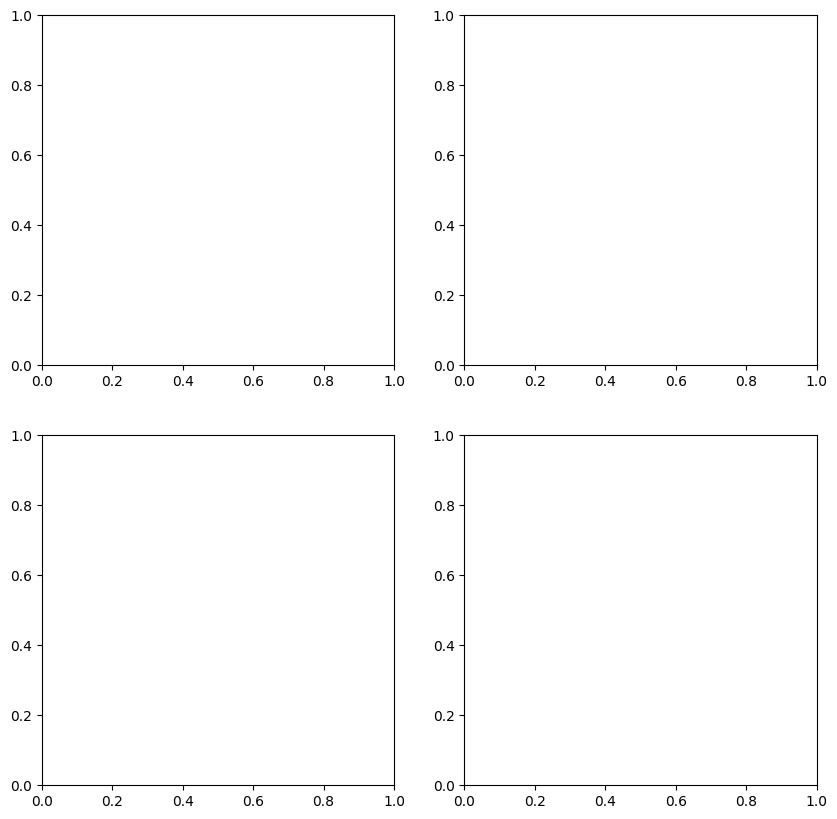

In [99]:
geom = dde.geometry.Rectangle([-1, -1], [1, 1])
bc = dde.icbc.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary)
fig_p, ax_p = plt.subplots(nrows=2, ncols=2)
fig_p.set_size_inches(10, 10)
fig_e, ax_e = plt.subplots(nrows=2, ncols=2)
fig_e.set_size_inches(10, 10)
fig_r, ax_r = plt.subplots(nrows=2, ncols=2)
fig_r.set_size_inches(10, 10)
for i, ns in enumerate(origin_ns):
    conditions = [bc]
    new_pde = partial(pde,n1=ns[0],n2=[ns[1]])
    certain = np.array([[[-0.5, 0.5]], [[0.5, -0.5]],[[-0.5, -0.5]],[[0.5, 0.5]],[[0, 0]]])
    values = get_value(certain, ns[0],ns[1])
    constr = initial_points(certain, values)
    conditions.extend(constr)
    data = dde.data.PDE(
        geom, 
        new_pde, 
        conditions, 
        num_domain = 800,
        num_boundary = 100,
        num_test=10**3,
        solution=exact_sol,
    )
    layer_size = [2] + [20] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot normal"

    net = dde.maps.FNN(layer_size, activation, initializer)


    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])

    losshistory, train_state = model.train(iterations=2000)
    test_domain = generate_test_data(100)
    predicted_solution = get_solution(test_domain,model)
    graph_shreodinger(test_domain[:,0],test_domain[:,1],predicted_solution,"predicted",fig_p,ax_p,i%2,i//2)
    
    # exact_solution = np.hstack([exact_solution(el) for el in test_domain])
    # graph_shreodinger(test_domain[:,0],test_domain[:,1],exact_solution,"exact",fig_e,ax_e,i%2,i//2)

    # error_l2 = (np.abs(predicted_solution - exact_solution)/exact_solution)**2
    # graph_shreodinger(test_domain[:,0],test_domain[:,1],error_l2,"error",fig_r,ax_r,i%2,i//2)